In [1]:
%load_ext autoreload
%autoreload 2

import os
import time

import sys
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *

sys.path.append('/oasis/projects/nsf/csd181/yuncong/opencv-2.4.9/release/lib/python2.7/site-packages')
import cv2

from joblib import Parallel, delayed

import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
from skimage.filters.rank import entropy
from skimage.morphology import remove_small_objects, disk, remove_small_holes
from skimage.measure import label, regionprops
from skimage.color import rgb2gray
from skimage.io import imread, imsave
from skimage import img_as_float

from sklearn import mixture
from sklearn.cluster import KMeans

In [3]:
# def generate_mask(img):

#     h, w = img.shape
    
#     e = entropy(img, disk(5))
    
#     clf = mixture.GMM(n_components=2, covariance_type='full')
#     clf.fit(np.atleast_2d(e[e > 0.1]).T)

#     means = np.squeeze(clf.means_)

#     order = np.argsort(means)
#     means = means[order]

#     covars =np.squeeze(clf.covars_)
#     covars = covars[order]

#     weights = clf.weights_
#     weights = weights[order]

#     counts, bins = np.histogram(e.flat, bins=100, density=True);

#     gs = np.array([w * 1./np.sqrt(2*np.pi*c) * np.exp(-(bins-m)**2/(2*c)) for m, c, w in zip(means, covars, weights)])

#     thresh = bins[np.where(gs[-1] - gs[-2] < 0)[0][-1]]

#     v = e > thresh

#     l = label(v, background=0)
#     mask = l == np.argmax([p.area for p in regionprops(l+1)])
    
#     mask = ~remove_small_objects(~mask, min_size=10000, connectivity=8)
    
#     l = label(v)
#     l[v > 0] = -1
#     props = regionprops(l)
    
#     border_holes = np.where([np.any(p.coords[:,0] == 0) or np.any(p.coords[:,1] == 0) \
#                              or np.any(p.coords[:,0] == h-1) or np.any(p.coords[:,1] == w-1) 
#                              for p in props])[0]

#     for i in border_holes:
#         c = props[i].coords
#         mask[c[:,0], c[:,1]] = 0
    
#     return mask

num. components 3
4.92472580309


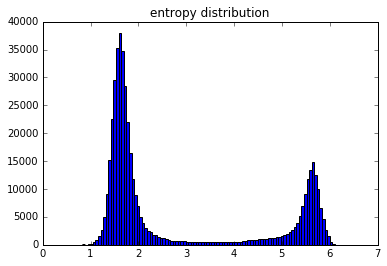

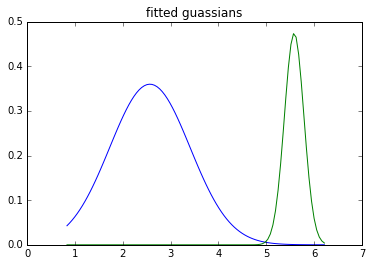

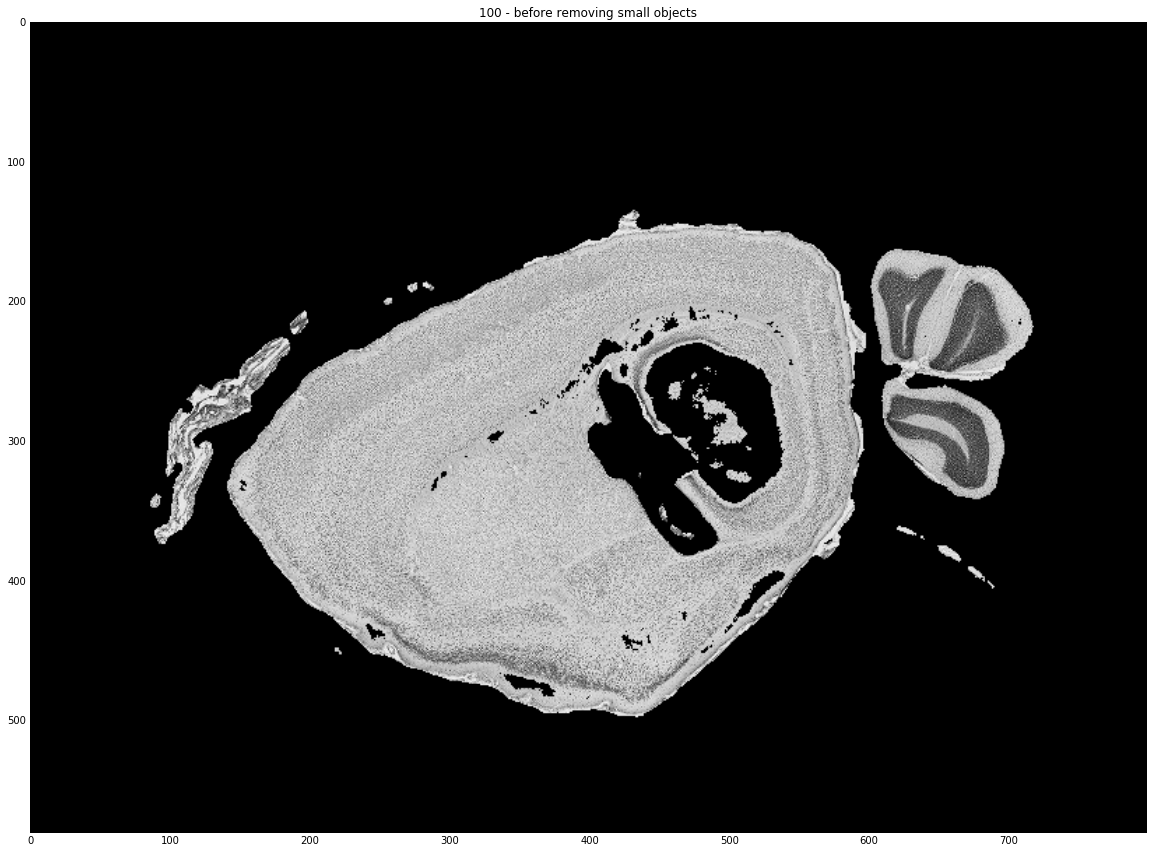

[99811, 13540, 30, 35, 24, 32, 2, 135, 2, 1, 3, 3, 2, 10, 6, 2, 3, 71, 1, 7, 1, 1, 8, 4, 5, 2, 1, 1, 3, 86, 7, 2, 1, 3662, 1, 242, 4, 11522, 1, 1, 1, 8, 43, 7, 2, 1, 1, 13, 1, 1, 44, 2, 2, 91, 1, 1, 2, 3, 553, 4, 1, 1, 7, 2, 3, 8, 3, 12, 1, 1, 1, 1, 50, 64, 1, 8, 2, 16, 2, 1, 1, 26, 105, 15, 7, 1, 24, 20, 54, 46, 65, 43, 5, 9, 92, 51, 345, 10, 1, 1, 15, 67, 15, 2, 1, 63, 9, 1, 1, 3, 13, 14, 1, 237, 1, 2]


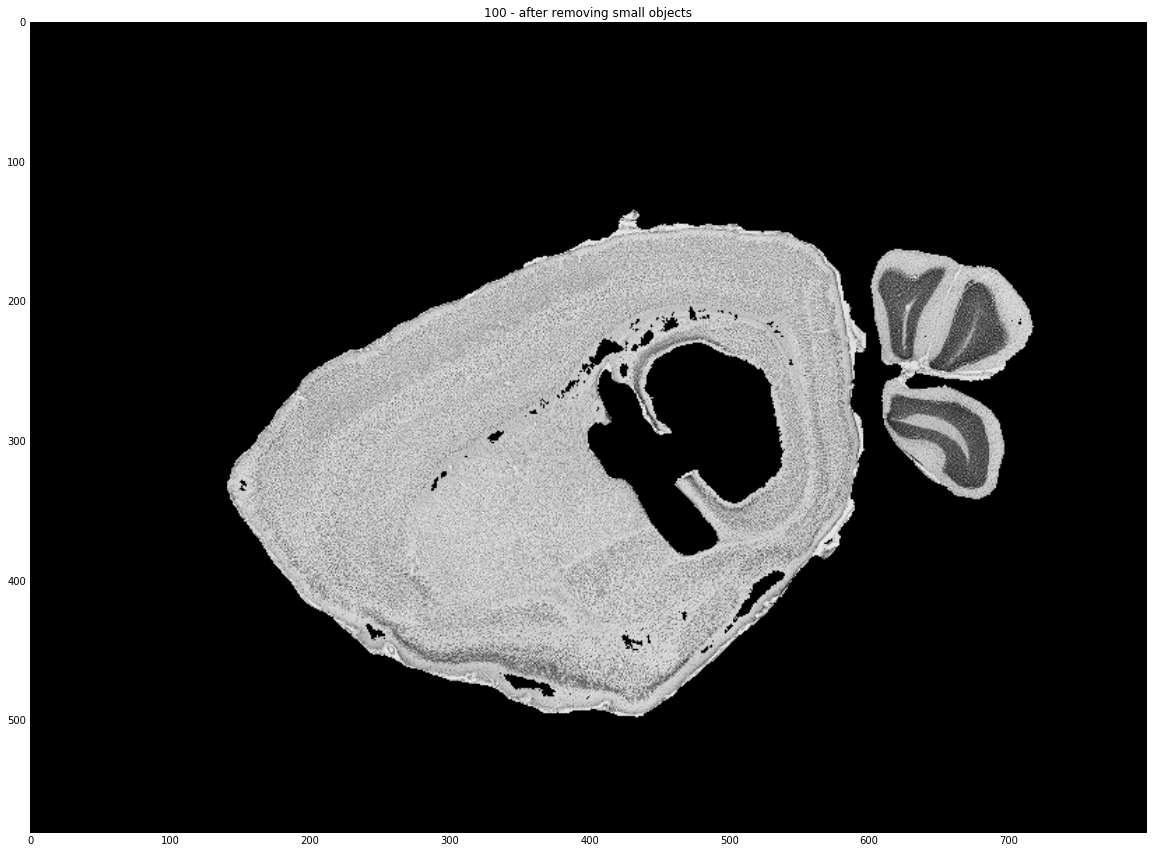

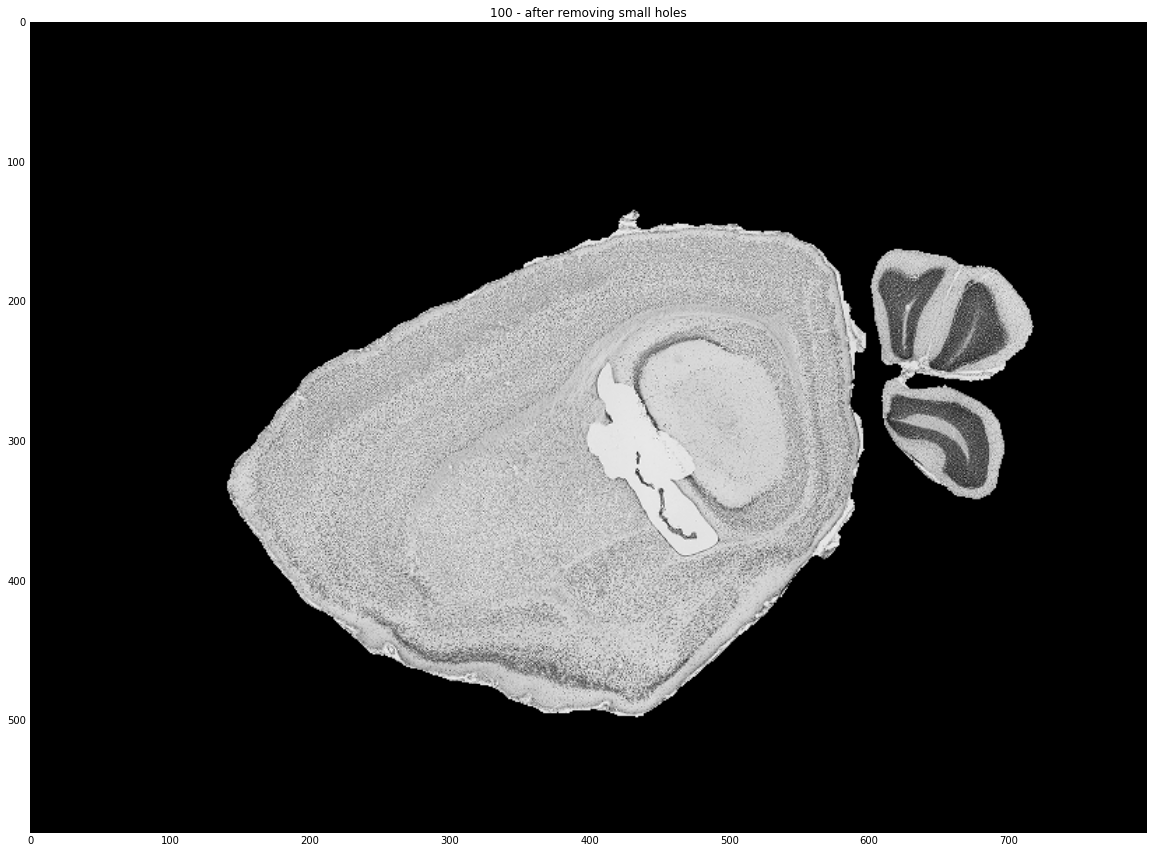

In [109]:
# WARNING!!! This is problematic when the entropy distribution is not gaussian, but skewed 
# This article about peak finding might help

s = 100

# img_rgb = imread('/home/yuncong/CSHL_data_processed/MD603/MD603_thumbnail_sorted_aligned/MD603_%04d_thumbnail_aligned.tif' % s)
# img = rgb2gray(img_rgb)

# img = rgb2gray(imread('/home/yuncong/CSHL_data/MD585/MD585-IHC6-2015.07.16-14.42.32_MD585_2_0017.tif'))
# img = rgb2gray(imread('/home/yuncong/CSHL_data/MD585/MD585-N3-2015.07.16-19.48.34_MD585_2_0008.tif'))
img = rgb2gray(imread('/home/yuncong/CSHL_data/MD594/MD594-N12-2015.08.26-21.27.37_MD594_1_0034.tif'))


h, w = img.shape
e = entropy(img, disk(5))

plt.figure();
plt.title('entropy distribution');
plt.hist(e.flatten(), bins=100);

x = np.atleast_2d(e[e > .1]).T

bics = []
clfs = []
# for nc in [3]:
for nc in [2,3]:
# for nc in [2]:
    clf = mixture.GMM(n_components=nc, covariance_type='full')
    clf.fit(x)
    bic = clf.bic(x)
    bics.append(bic)
    clfs.append(clf)
    
print 'num. components', [2,3][np.argsort(bics)[0]]

clf = clfs[np.argsort(bics)[0]]

means = np.atleast_1d(np.squeeze(clf.means_))

order = np.argsort(means)
# means = means[order]

# covars = np.squeeze(clf.covars_)
covars = np.atleast_1d(np.squeeze(clf.covars_))
# covars = covars[order]

weights = clf.weights_
# weights = weights[order]

new_means = []
new_covs = []
new_weights = []

# Force into 2 classes: foreground and background
km = KMeans(2)
km.fit([[x]for x in means])
for l in set(km.labels_):
    new_mean = means[km.labels_ == l].mean()
    new_cov = covars[km.labels_ == l].mean()
    new_weight = weights[km.labels_ == l].sum()
    
    new_means.append(new_mean)
    new_covs.append(new_cov)
    new_weights.append(new_weight)

order = np.argsort(new_means)
new_means = np.array(new_means)[order]
new_covs = np.array(new_covs)[order]
new_weights = np.array(new_weights)[order]

counts, bins = np.histogram(e.flat, bins=100, density=True);

# ignore small components
gs = np.array([w * 1./np.sqrt(2*np.pi*c) * np.exp(-(bins-m)**2/(2*c)) for m, c, w in zip(new_means, new_covs, new_weights)])

plt.figure();
plt.title('fitted guassians');
plt.plot(bins, gs.T);

thresh = bins[np.where(gs[-1] - gs[-2] < 0)[0][-1]]
# thresh = 4
print thresh

mask = e > thresh

# from skimage.morphology import opening
# mask = opening(mask, selem=disk(5))

img2 = img.copy()
img2[~mask] = 0

plt.figure(figsize=(20,20));
plt.imshow(img2, cmap=plt.cm.gray);
plt.title('%d - before removing small objects' % s);
plt.show();

# mask_rso = remove_small_objects(mask, min_size=10000, connectivity=8)

# img2 = img.copy()
# img2[~mask_rso] = 0

# plt.figure(figsize=(20,20));
# plt.imshow(img2, cmap=plt.cm.gray);
# plt.title('%d - before filling holes' % s);
# plt.show();

# mask_rsh = remove_small_holes(mask_rso, min_size=10000, connectivity=8)

# img2 = img.copy()
# img2[~mask_rsh] = 0

# plt.figure(figsize=(20,20));
# plt.imshow(img2, cmap=plt.cm.gray);
# plt.title('%d - after filling holes' % s);
# plt.show();
    
# if np.count_nonzero(mask_rsh) < 10:

component_areas = [p.area for p in regionprops(label(mask))]
print component_areas
max_area = np.max(component_areas)
min_size = min(max_area, 5000)

mask_rso = remove_small_objects(mask, min_size=min_size, connectivity=8)

img2 = img.copy()
img2[~mask_rso] = 0
plt.figure(figsize=(20,20));
plt.imshow(img2, cmap=plt.cm.gray);
plt.title('%d - after removing small objects' % s);
plt.show();


mask_rsh = remove_small_holes(mask_rso, min_size=20000, connectivity=8)

img2 = img.copy()
img2[~mask_rsh] = 0
plt.figure(figsize=(20,20));
plt.imshow(img2, cmap=plt.cm.gray);
plt.title('%d - after removing small holes' % s);
plt.show();

In [99]:
from skimage.measure import find_contours
from annotation_utilities import *
from skimage.segmentation import active_contour
from skimage.filters import gaussian
from skimage.filter import threshold_adaptive, canny

In [100]:
entropy_mask = mask_rsh

In [101]:
init_contours = [yxs[:,::-1] for yxs in find_contours(entropy_mask, .5) if len(yxs) > 50]
# assert len(init_contours) > 0, 'No contour is detected from entropy mask %s' % fn
print len(init_contours)

img_adap = threshold_adaptive(img, 51)
img_adap[~entropy_mask] = 1

1


In [102]:
final_masks = []

for init_cnt in init_contours:

# init_cnt = init_contours[0]
    snake = active_contour(img_adap, init_cnt,
                           alpha=1., beta=10., gamma=0.01,
                           w_line=0., w_edge=1.,
                           max_iterations=100)

    bg = np.zeros(img.shape[:2], bool)
    xys = points_inside_contour(snake.astype(np.int))
    bg[np.minimum(xys[:,1], bg.shape[0]-1), np.minimum(xys[:,0], bg.shape[1]-1)] = 1

    final_mask = bg & entropy_mask
    final_masks.append(final_mask)

try:
#     if len(final_masks) >= 2:
    final_mask = np.any(final_masks, axis=0)
#     else:
#         final_mask = final_masks[0]
except Exception as e:
    sys.stderr.write(e.message + '\n')
    sys.stderr.write('%d, Mask error: %s\n' % (len(final_masks), fn))

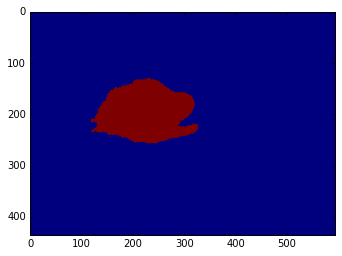

In [103]:
plt.imshow(final_mask)

In [ ]:
# for init_cnt in init_contours[1:]:

init_cnt = init_contours[0]

t = time.time()

# alpha: length
# beta: second order

snake = active_contour(img_adap, init_cnt, 
                       alpha=1., beta=10., gamma=0.01, 
                       w_line=0., w_edge=1., 
                       max_iterations=1000)
#                        convergence=.01)

print time.time() - t

In [ ]:
bg = np.zeros(img.shape[:2], bool)
xys = points_inside_contour(snake.astype(np.int))
bg[xys[:,1], xys[:,0]] = 1

In [ ]:
final_cnt = find_contours(bg & mask, .5)[0]

In [ ]:
fig = plt.figure(figsize=(30, 30));

plt.imshow(img_adap[ymin:ymax+1, xmin:xmax+1])
plt.plot(init_cnt[:, 0]-xmin, init_cnt[:, 1]-ymin, '--r', lw=3)
plt.plot(snake[:, 0]-xmin, snake[:, 1]-ymin, '-g', lw=3)
plt.plot(final_cnt[:, 1]-xmin, final_cnt[:, 0]-ymin, '-b', lw=3)

plt.show()

In [ ]:
plt.hist(e[e>.1], bins=100);

In [ ]:
plt.imshow(e);
plt.colorbar();

In [ ]:
xmin, xmax, ymin, ymax = bbox_2d(img2)

img3 = img2[ymin-10:ymax+10, xmin-10:xmax+10].copy()

h, w = img3.shape[:2]
init = np.r_[np.c_[np.arange(w), np.zeros((w,))], 
             np.c_[w*np.ones((h,)), np.arange(h)], 
             np.c_[np.arange(w, 0, -1), h*np.ones((w,))], 
             np.c_[np.zeros((h,)), np.arange(h, 0, -1)]]

In [ ]:
sys.path.append('/home/yuncong/Brain/preprocess/morphsnakes')
import morphsnakes
from collections import deque
from registration_utilities import *

scoremap_viz = img_as_ubyte(img3.copy())

In [ ]:
init_levelset = np.zeros((h, w))
init_levelset[10:-10, 10:-10] = 1.
# init_levelset[inside_points_inroi[:,1], inside_points_inroi[:,0]] = 1.

t = time.time()

msnake = morphsnakes.MorphACWE(img3.astype(np.float), smoothing=3, lambda1=1., lambda2=1.)

msnake.levelset = init_levelset.copy()

dq = deque([None, None])
for i in range(1000): 

    # at stable stage, the levelset (thus contour) will oscilate, 
    # so instead of comparing to previous levelset, must compare to the one before the previous
    oneBefore_levelset = dq.popleft()

    if i > 10:
#                 print np.count_nonzero(msnake.levelset - oneBefore_levelset)
        if np.count_nonzero(msnake.levelset - oneBefore_levelset) < 3:
            break

    dq.append(msnake.levelset)

    msnake.step()

    if i % 50 == 0:
        show_levelset(msnake.levelset, scoremap_viz, 'iteration %d' % i)

show_levelset(msnake.levelset, scoremap_viz, 'iteration %d' % i)

# # in the final levelset, inside could be 0. or 1., hard to say        
# edge_arr = np.r_[msnake.levelset[:,0], msnake.levelset[:,-1], msnake.levelset[0], msnake.levelset[-1]]        
# pos_edge_num = np.count_nonzero(edge_arr)
# bool_arr = msnake.levelset.astype(np.bool)

# if pos_edge_num < len(edge_arr) - pos_edge_num:
#     # inside is 1.
#     mean_inside_score = scoremap_roi[bool_arr].mean()
# else:
#     # inside is 0.
#     mean_inside_score = scoremap_roi[~bool_arr].mean()
#     msnake.levelset = 1. - msnake.levelset

# # after this, all inside pixels have value 1.

# print 'mean inside score:', mean_inside_score
# print 'area:', np.count_nonzero(bool_arr)
# print 'snake iteration:', i

# if mean_inside_score < .3:
#     continue

# sys.stderr.write('snake completes %f s\n' % (time.time() - t))

# #         m = binary_closing(msnake.levelset, disk(20))
# #         plt.figure(figsize=(10,10));
# #         plt.imshow(m);
# #         plt.show();

# t = time.time()

# new_cnts = find_contours(msnake.levelset, 0.5)
# new_cnts = [c[:, ::-1] for c in new_cnts]

In [ ]:
from skimage.segmentation import active_contour
cnt = active_contour(img3, init.astype(np.float), alpha=.1, beta=.001, gamma=0.001, w_edge=10.)

img4 = img3.copy()
# img4[cnt[:,1].astype(np.int), cnt[:,0].astype(np.int)] = 1.
cv2.polylines(img4, [cnt.astype(np.int)], True, (1.,1.,1.))
plt.figure(figsize=(20,20));
plt.imshow(img4, cmap=plt.cm.gray);

In [ ]:
plt.imshow(e);
plt.colorbar();